In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
i

In [3]:
save_data = True

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# expt_path=os.getcwd()+'\data_220623'
expt_path=os.getcwd()+'\data_220712'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_220712


In [6]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


# Qubit/resonator to probe

In [7]:
all_results = [dict(), dict(), dict(), dict()]

In [8]:
qubit_i = 0
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [17]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [10]:
im = InstrumentManager()

In [25]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 10.0


In [11]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# RFSoC Calibration

In [51]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1, # [us]
    readout_length=2, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)
tof.go(analyze=False, display=False, progress=True, save=False)

430 614
readout freq 950 +/- 811


  0%|          | 0/500 [00:00<?, ?it/s]

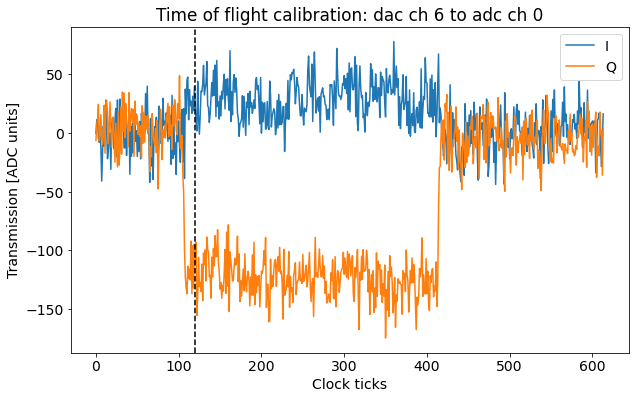

In [21]:
tof.display(adc_trig_offset=120)

# Initial single tone resonator spectroscopy

In [304]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 200
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain = 0.035
rspec.cfg.device.readout.relax_delay = 2 # Wait time between experiments [us]
rspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/200 [00:00<?, ?it/s]


Freq with minimum transmission: 80.36674469403594
From fit:
	f0: 79.33727631616162
	Qi: 5014.555331162278
	Qe: 326.48462304804275
	Q0: 306.5274218286816
	kappa [MHz]: 0.25882603208173416
	phi [radians]: 2.6210408216841503


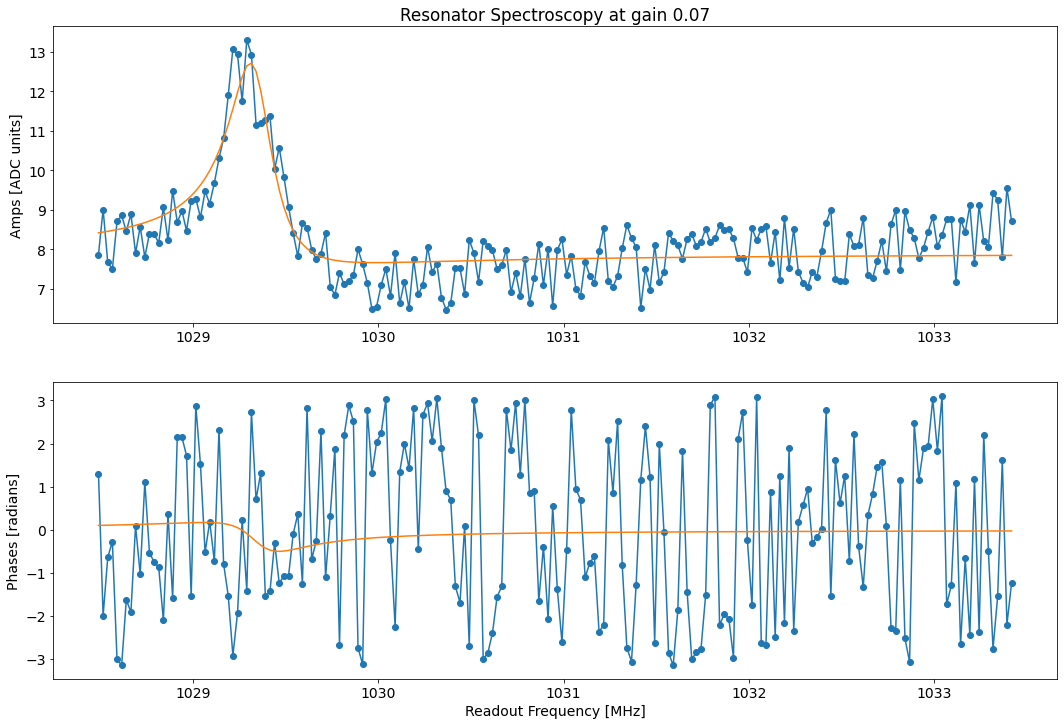

*Set cfg res 3 freq to 79.33727631616162*
[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E err': 1.069072170

In [305]:
 # TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
if not isinstance(rspec_fit, (list, np.ndarray)):
    rspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(all_results)

In [225]:
if save_data: rspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00000_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [226]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 180
npts = 180

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=500, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in I at [MHz] 448.8623332879169, HWHM -3.5469036736230044
Found peak in Q at [MHz] 449.12854295027097, HWHM 3.4624631255351153


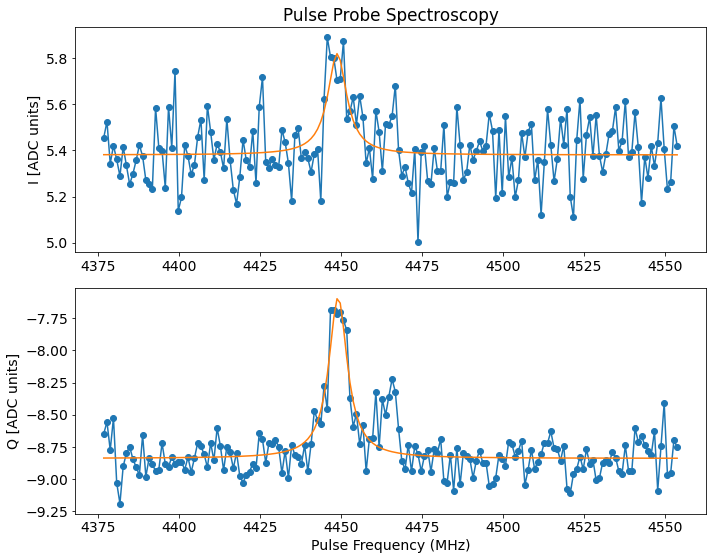

*Set qubit 3 f_ge to 449.12854295027097*
[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E err': 1.0690721702

In [238]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[0] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[1] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

better_fit = (qspec.data['fit_avgi'], qspec.data['fit_avgq'])[np.argmin((qspec.data['fit_err_avgi'][2][2], qspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ge[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [228]:
if save_data: qspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00000_qubit_spectroscopy_qubit3.h5


## Pulse Probe (qubit) spectroscopy round 2

In [267]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 30
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=500, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in I at [MHz] 448.9672198866197, HWHM 2.325215097478391
Found peak in Q at [MHz] 448.97481447211254, HWHM 2.8922286958402426


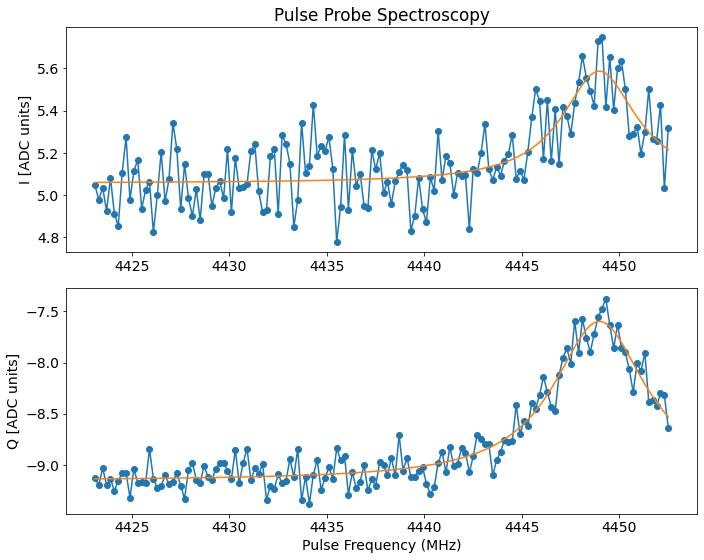

*Set qubit 3 f_ge to 448.97481447211254*
[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E err': 1.0690721702

In [268]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[sign, sign])
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[0] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[1] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    rspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

better_fit = (qspec2.data['fit_avgi'], qspec2.data['fit_avgq'])[np.argmin((qspec2.data['fit_err_avgi'][2][2], qspec2.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ge[qubit_i] = better_fit[2]
qubit_hwhm = better_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [231]:
if save_data: qspec2.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_qubit_spectroscopy_qubit3.h5


## Amplitude Rabi

In [353]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 101
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=500,
    # reps=5,
    # sigma_test=0.025, # gaussian sigma for pulse length - overrides config [us]
    rounds=20,
    pulse_type='gauss',
    qubit=qubit_i,
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Pi gain from avgi data [dac units]: 17502
	Pi/2 gain from avgi data [dac units]: 8751
Pi gain from avgq data [dac units]: 10606
	Pi/2 gain from avgq data [dac units]: 5303


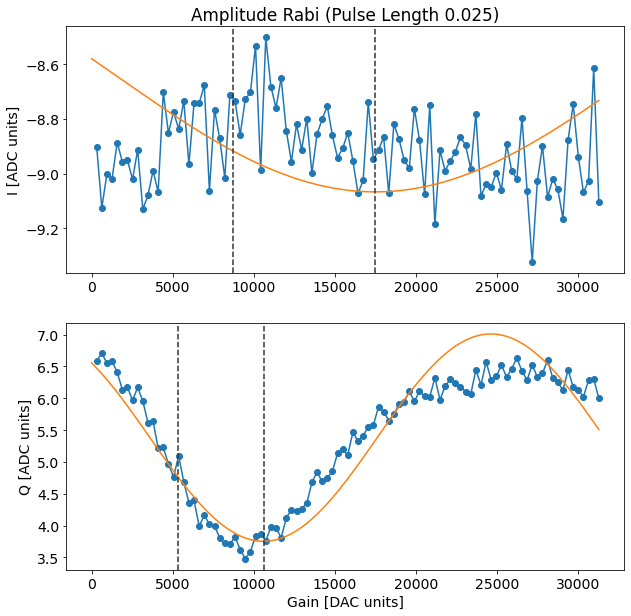

*Set pi pulse sigma for qubit 3 to 0.025*
*Set pi pulse gain for qubit 3 to 10606*
[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E':

In [354]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit = (amprabi.data['fit_amps'], amprabi.data['fit_avgi'], amprabi.data['fit_avgq'])[np.argmin((amprabi.data['fit_err_amps'][1][1], amprabi.data['fit_err_avgi'][1][1], amprabi.data['fit_err_avgq'][1][1]))]

if not isinstance(amprabi_fit, (list, np.ndarray)):
    amprabi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test
p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]
print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(all_results)

In [359]:
if save_data: amprabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00002_amp_rabi_qubit3.h5


## $T_1$

In [269]:
short_T1 = True

In [270]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 200
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=500,
    # reps=5,
    rounds=20,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = 400 # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\fitting.py:10: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


Fit T1 avgi [us]: 3.5388842755903465
Fit T1 avgq [us]: 4.928890386924494


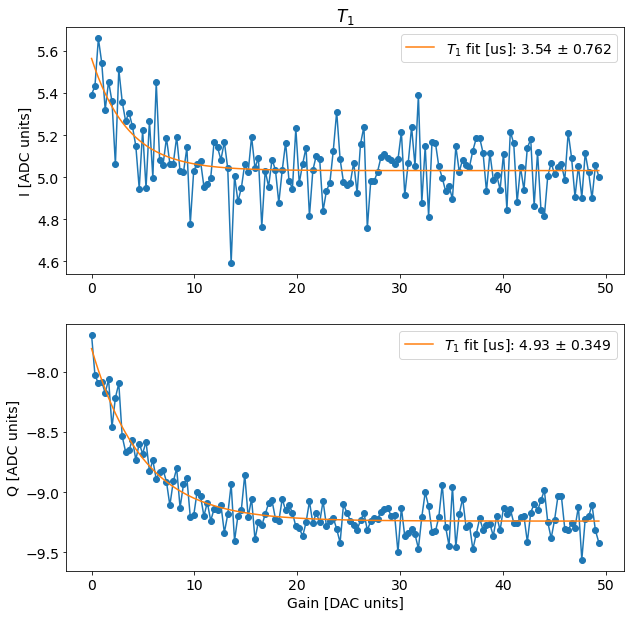

*Set qubit 3 T1 to 5.0*
*Set readout 3 relax delay to 15.0*
[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E

In [271]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)
i_best = np.argmin((t1.data['fit_err_amps'][3][3], t1.data['fit_err_avgi'][3][3], t1.data['fit_err_avgq'][3][3]))
t1_fit = (t1.data['fit_amps'], t1.data['fit_avgi'], t1.data['fit_avgq'])[i_best]
t1_fit_err = (t1.data['fit_err_amps'], t1.data['fit_err_avgi'], t1.data['fit_err_avgq'])[i_best]

if not isinstance(t1_fit, (list, np.ndarray)):
    t1.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(3*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(all_results)

In [272]:
if save_data: t1.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00002_t1_qubit3.h5


## $T_2$ Ramsey round 1

In [355]:
ramsey_freq = max(min(np.abs(np.ceil(qubit_hwhm)), 4), 2)

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=500,
    # reps=5,
    rounds=20,
    qubit=qubit_i,
)
t2r.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 34.99965, which is out of bounds 0.11744848993288592 to 23.489697986577184. Instead init to 11.803573238255035
Current qubit frequency: 449.75718765473
Fit frequency from I [MHz]: 4.680751517693702 +/- 0.21713191839628074
Suggested new qubit frequency from fit I [MHz]:
 	448.0764361370363
 	442.0764361370363
T2 Ramsey from fit I [us]: 0.2937282866771263
Fit frequency from Q [MHz]: 4.780021005055796 +/- 0.03307950629232971
Suggested new qubit frequencies from fit Q [MHz]:
 	447.9771666496742
 	441.9771666496742
T2 Ramsey from fit Q [us]: 0.32861222061838957


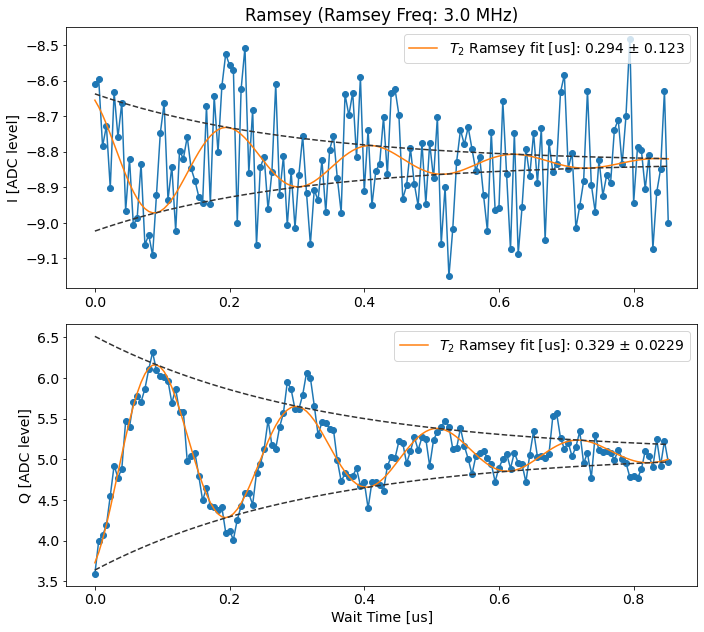

*Set qubit 3 freq to 447.9771666496742*


In [356]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)
i_best = np.argmin((t2r.data['fit_err_amps'][3][3], t2r.data['fit_err_avgi'][3][3], t2r.data['fit_err_avgq'][3][3]))
t2r_fit = (t2r.data['fit_amps'], t2r.data['fit_avgi'], t2r.data['fit_avgq'])[i_best]
t2r_fit_err = (t2r.data['fit_err_amps'], t2r.data['fit_err_avgi'], t2r.data['fit_err_avgq'])[i_best]
t2r_adjust = (t2r.data['f_ge_adjust_ramsey_amps'], t2r.data['f_ge_adjust_ramsey_avgi'], t2r.data['f_ge_adjust_ramsey_avgq'])[i_best]
old_qubit_freq = t2r.cfg.device.qubit.f_ge

if not isinstance(t2r_fit, (list, np.ndarray)):
    t2r.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

In [275]:
if save_data: t2r.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00004_ramsey_qubit3.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [276]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/2, # [MHz]
    reps=500,
    # reps=10,
    rounds=20,
    qubit=qubit_i,
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 32.66634, which is out of bounds 0.11744848993288592 to 23.489697986577184. Instead init to 11.803573238255035
Current qubit frequency: 449.65572611530354
Fit frequency from I [MHz]: 1.2871021979005368 +/- 0.08884182201923527
Suggested new qubit frequency from fit I [MHz]:
 	449.868623917403
 	446.868623917403
T2 Ramsey from fit I [us]: 1.0591290315038568
Fit frequency from Q [MHz]: 1.3985384605735551 +/- 0.0431186087921563
Suggested new qubit frequencies from fit Q [MHz]:
 	449.75718765473
 	446.75718765473
T2 Ramsey from fit Q [us]: 0.7177392165604328


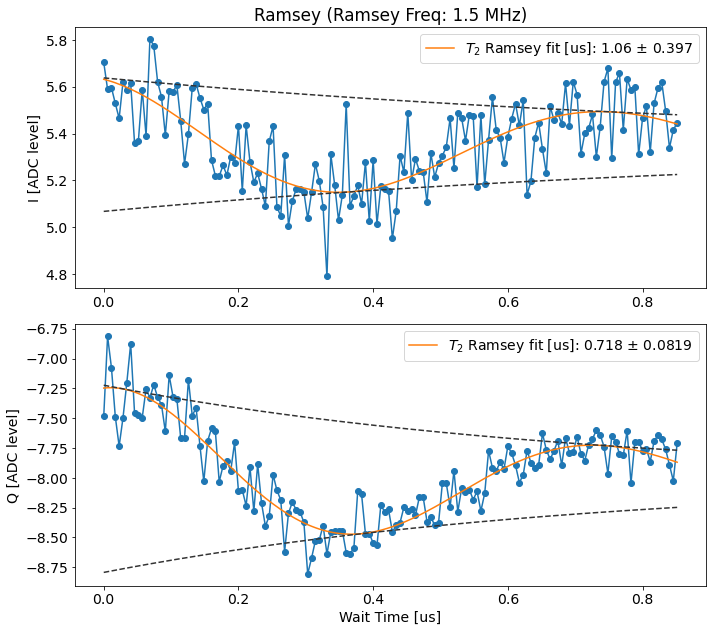

*Set qubit 3 freq to 449.75718765473*
[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E err': 1.0690721702816

In [277]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

i_best = np.argmin((t2r_2.data['fit_err_amps'][3][3], t2r_2.data['fit_err_avgi'][3][3], t2r_2.data['fit_err_avgq'][3][3]))
t2r_2_fit = (t2r_2.data['fit_amps'], t2r_2.data['fit_avgi'], t2r_2.data['fit_avgq'])[i_best]
t2r_2_fit_err = (t2r_2.data['fit_err_amps'], t2r_2.data['fit_err_avgi'], t2r_2.data['fit_err_avgq'])[i_best]
t2r_2_adjust = (t2r_2.data['f_ge_adjust_ramsey_amps'], t2r_2.data['f_ge_adjust_ramsey_avgi'], t2r_2.data['f_ge_adjust_ramsey_avgq'])[i_best]

if not isinstance(t2r_2_fit, (list, np.ndarray)):
    t2r_2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    i_best = np.argmin([t2r_fit_err[3][3], t2r_2_fit_err[3][3]])
    results_Qi.update({'T2R':[t2r_fit[3], t2r_2_fit[3]][i_best], 'T2R err':np.sqrt([t2r_fit_err[3][3], t2r_2_fit_err[3][3]][i_best])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(all_results)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [278]:
if save_data: t2r_2.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00005_ramsey_qubit3.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [279]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=500,
        # reps=10,
        rounds=20,
        qubit=qubit_i,
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [280]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    i_best = np.argmin((t2r_3.data['fit_err_amps'][3][3], t2r_3.data['fit_err_avgi'][3][3], t2r_3.data['fit_err_avgq'][3][3]))
    t2r_3_fit = (t2r_3.data['fit_amps'], t2r_3.data['fit_avgi'], t2r_3.data['fit_avgq'])[i_best]
    t2r_3_fit_err = (t2r_3.data['fit_err_amps'], t2r_3.data['fit_err_avgi'], t2r_3.data['fit_err_avgq'])[i_best]
    t2r_3_adjust = (t2r_3.data['f_ge_adjust_ramsey_amps'], t2r_3.data['f_ge_adjust_ramsey_avgi'], t2r_3.data['f_ge_adjust_ramsey_avgq'])[i_best]

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [281]:
if redo_t2r:
    if save_data: t2r_3.save_data()

## $T_2$ Echo

In [282]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(10), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max(ramsey_freq/4, 0.300), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=500,
    # reps=10,
    rounds=20,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 15.866508, which is out of bounds 0.023489697986577185 to 4.697939597315436. Instead init to 2.360714647651007
Current qubit frequency: 449.75718765473
Fit frequency from I [MHz]: 0.7772416393460614 +/- 0.02913760114111887
Suggested new qubit frequency from fit I [MHz]:
 	449.7299460153839
 	448.2299460153839
T2 Echo from fit I [us]: 1.584107397680213
Fit frequency from Q [MHz]: 0.77414847644967 +/- 0.011221745580930321
Suggested new qubit frequencies from fit Q [MHz]:
 	449.7330391782803
 	448.2330391782803
T2 Echo from fit Q [us]: 2.1193876599315216


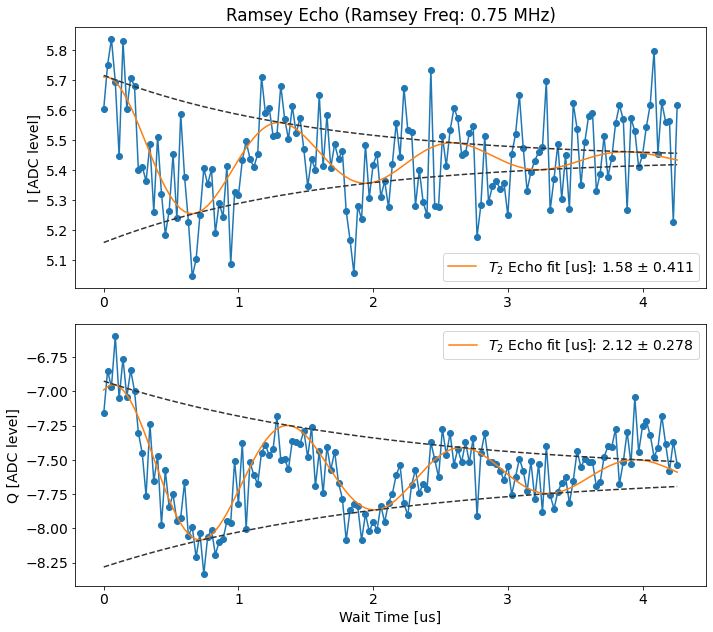

[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E err': 1.0690721702816643, 'Res chi shift (e - g)': -1.05147

In [283]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

i_best = np.argmin((t2e.data['fit_err_avgi'][3][3], t2e.data['fit_err_avgq'][3][3]))
t2e_fit = (t2e.data['fit_avgi'], t2e.data['fit_avgq'])[i_best]
t2e_fit_err = (t2e.data['fit_err_avgi'], t2e.data['fit_err_avgq'])[i_best]
t2e_adjust = (t2e.data['f_ge_adjust_ramsey_avgi'], t2e.data['f_ge_adjust_ramsey_avgq'])[i_best]

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(all_results)
# print('Results updated.')

In [284]:
if save_data: t2e.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00000_echo_qubit3.h5


# Resonator chi shift (g/e)

In [357]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 200
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=10000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/200 [00:00<?, ?it/s]


Freq with minimum transmission: 79.66227631616162
From fit:
	f0: 79.51511598871058
	Qi: 242.4486472153797
	Qe: 96.00188076429976
	Q0: 68.7708370862229
	kappa [MHz]: 1.1562330685173545
	phi [radians]: 1.0371484549740444


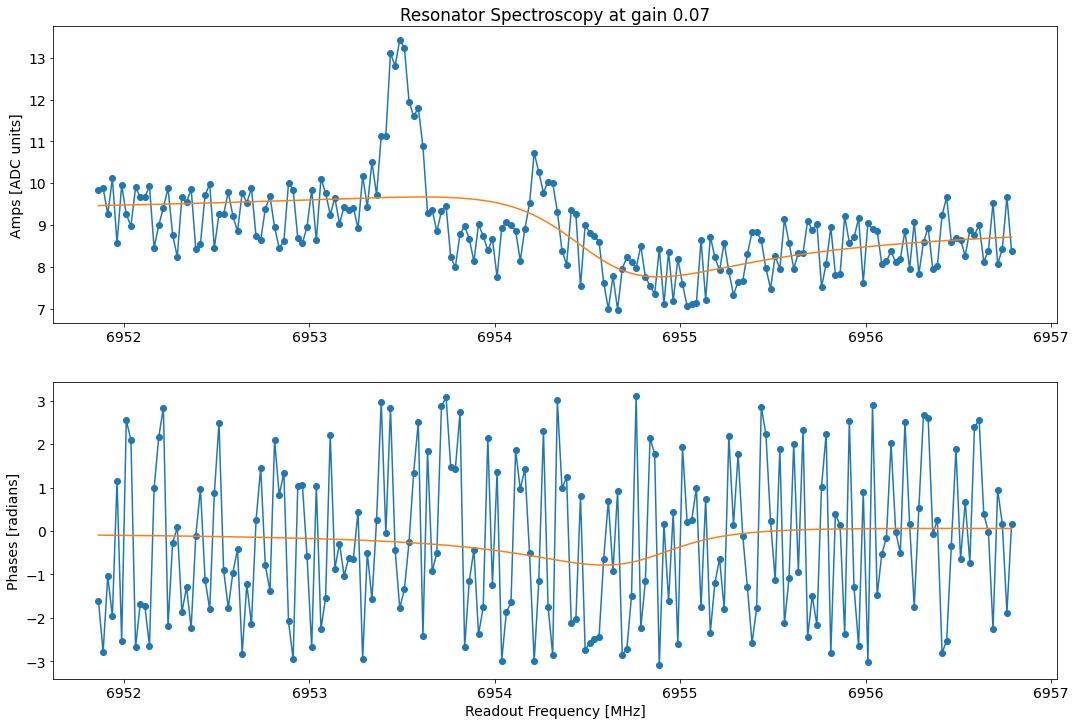

[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E err': 1.0690721702816643, 'Res chi shift (e - g)': -1.05147

In [358]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
res_freq_e = rspec_chi_fit[0]
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [341]:
if save_data: rspec_chi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [361]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 180
npts = 180

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=500, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=0.5, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

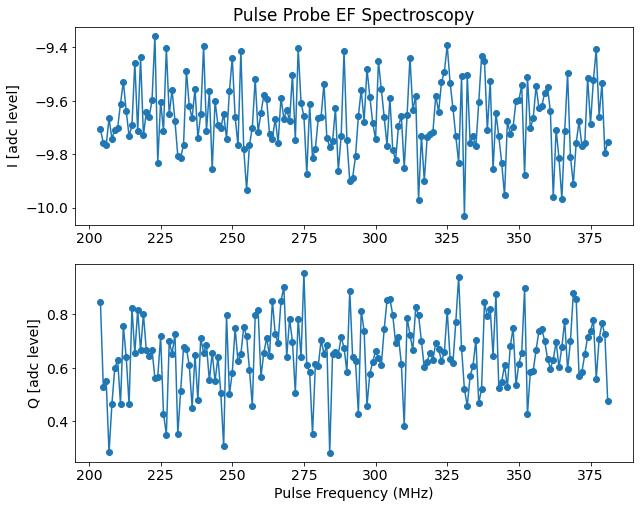

AssertionError: Fit failed, please manually fix!

In [364]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[0] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[1] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [466]:
if save_data: qEFspec.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_qubit_EF_spectroscopy_qubit0.h5


## Pulse Probe EF spectroscopy round 2

In [ ]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 30
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=500, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=0.5, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

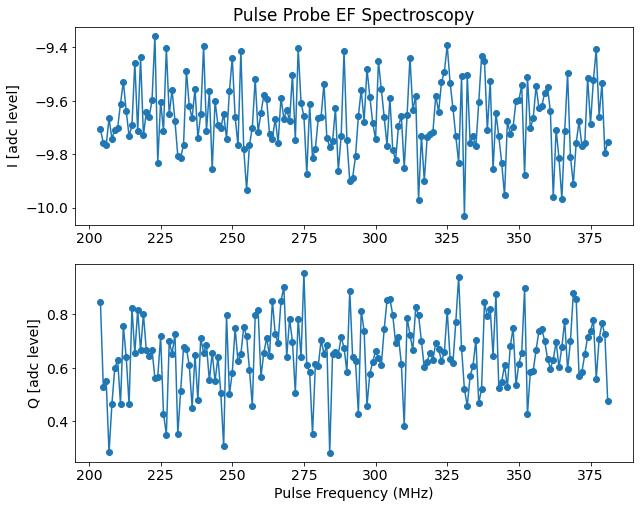

AssertionError: Fit failed, please manually fix!

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec2.analyze(fit=True, signs=[sign, sign])
        fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[0] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[1] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

better_fit = (qEFspec2.data['fit_avgi'], qEFspec2.data['fit_avgq'])[np.argmin((qEFspec2.data['fit_err_avgi'][2][2], qEFspec2.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
qubitEF_hwhm = better_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [ ]:
if save_data: qEFspec2.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_qubit_EF_spectroscopy_qubit0.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [13]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=50,
    rounds=10,
    # sigma_test=0.025, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': 70, 'f_ge': 743.119, 'f_ef': 649.12, 'f_EgGf': 2013, 'gs': 43, 'pulses': {'pi_ge': {'gain': 27145, 'sigma': 0.035, 'type': 'gauss'}, 'pi_ef': {'gain': 3006, 'sigma': 0.035, 'type': 'gauss'}, 'pi_EgGf': {'gain': 1000, 'sigma': 0.1, 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': 810.409984606071, 'lo_sideband': 1, 'gain': 0.085, 'readout_length': 10, 'relax_delay': 200}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'int4', 'mixer_freq': 4000, 'nyquist': 2}, 'swap': {'ch': 4, 'type': 'full', 'nyquist': 1}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 950, 'nyquist': 1}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 1, 'step': 316, 'expts': 101, 'reps': 50, 'rounds': 10, 'pulse_type': 'gauss', 'qubit': 0}}


  0%|          | 0/10 [00:00<?, ?it/s]

C:\_Lib\python\slab\datamanagement.py:245: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, *args, **kwargs)


Extracted data and attrs ['config']
Pi gain from avgi data [dac units]: 22325
	Pi/2 gain from avgi data [dac units]: 11162
Pi gain from avgq data [dac units]: 22501
	Pi/2 gain from avgq data [dac units]: 11250


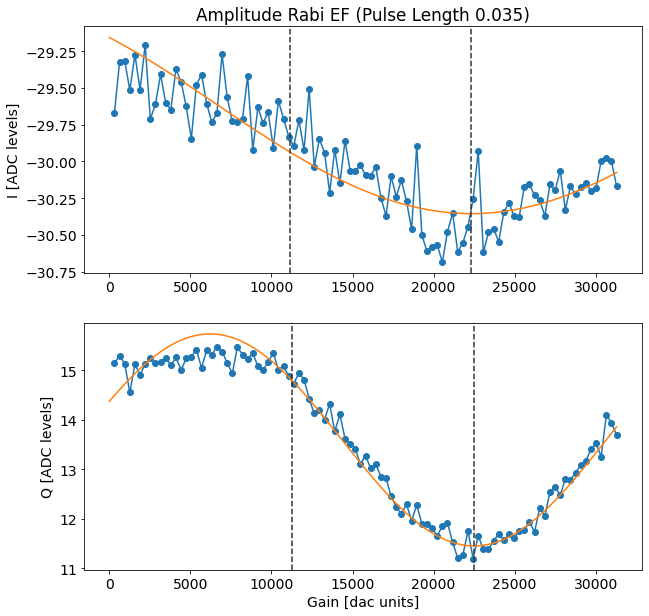

TypeError: 'float' object does not support item assignment

In [15]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
amprabiEF.data = temp_data

amprabiEF.analyze(fit=True)

amprabiEF_fit = (amprabiEF.data['fit_amps'], amprabiEF.data['fit_avgi'], amprabiEF.data['fit_avgq'])[np.argmin((amprabiEF.data['fit_err_amps'][1][1], amprabiEF.data['fit_err_avgi'][1][1], amprabiEF.data['fit_err_avgq'][1][1]))]

if not isinstance(amprabiEF_fit, (list, np.ndarray)):
    amprabiEF.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
amprabiEF.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
p = amprabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [34]:
if save_data: amprabiEF.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_amp_rabi_EF_qubit1.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [468]:
ramseyEF_freq = max(min(np.abs(np.ceil(qubitEF_hwhm)), 4), 2)

t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=500,
    rounds=30,
    qubit=qubit_i,
)
t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/20 [00:00<?, ?it/s]

Fit frequency from amps [MHz]: 8.935718332550108
Suggested new EF frequencies from fit amps [MHz]:
 	192.5642816674499
 	189.5642816674499
T2 Ramsey EF from fit amps [us]: 0.2038612082168112


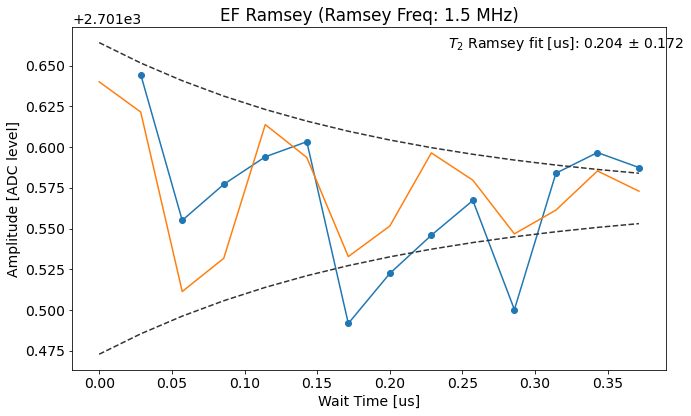

In [469]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
i_best = np.argmin((t2EFr.data['fit_err_amps'][3][3], t2EFr.data['fit_err_avgi'][3][3], t2EFr.data['fit_err_avgq'][3][3]))
t2EFr_fit = (t2EFr.data['fit_amps'], t2EFr.data['fit_avgi'], t2EFr.data['fit_avgq'])[i_best]
t2EFr_fit_err = (t2EFr.data['fit_err_amps'], t2EFr.data['fit_err_avgi'], t2EFr.data['fit_err_avgq'])[i_best]
t2EFr_adjust = (t2EFr.data['f_ef_adjust_ramsey_amps'], t2EFr.data['f_ef_adjust_ramsey_avgi'], t2EFr.data['f_ef_adjust_ramsey_avgq'])[i_best]
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

In [42]:
if save_data: t2EFr.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_ramseyEF_qubit1.h5


# Resonator chi shift (e/f)

In [ ]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2 # MHz
npts = 100
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-yaml_cfg.device.readout.lo_sideband[qubit_i]*results_Qi['Res chi shift (e - g)']-span, # [MHz]
    step=span/npts,
    expts=npts,
    reps=10000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/200 [00:00<?, ?it/s]


Freq with minimum transmission: 79.66227631616162
From fit:
	f0: 79.51511598871058
	Qi: 242.4486472153797
	Qe: 96.00188076429976
	Q0: 68.7708370862229
	kappa [MHz]: 1.1562330685173545
	phi [radians]: 1.0371484549740444


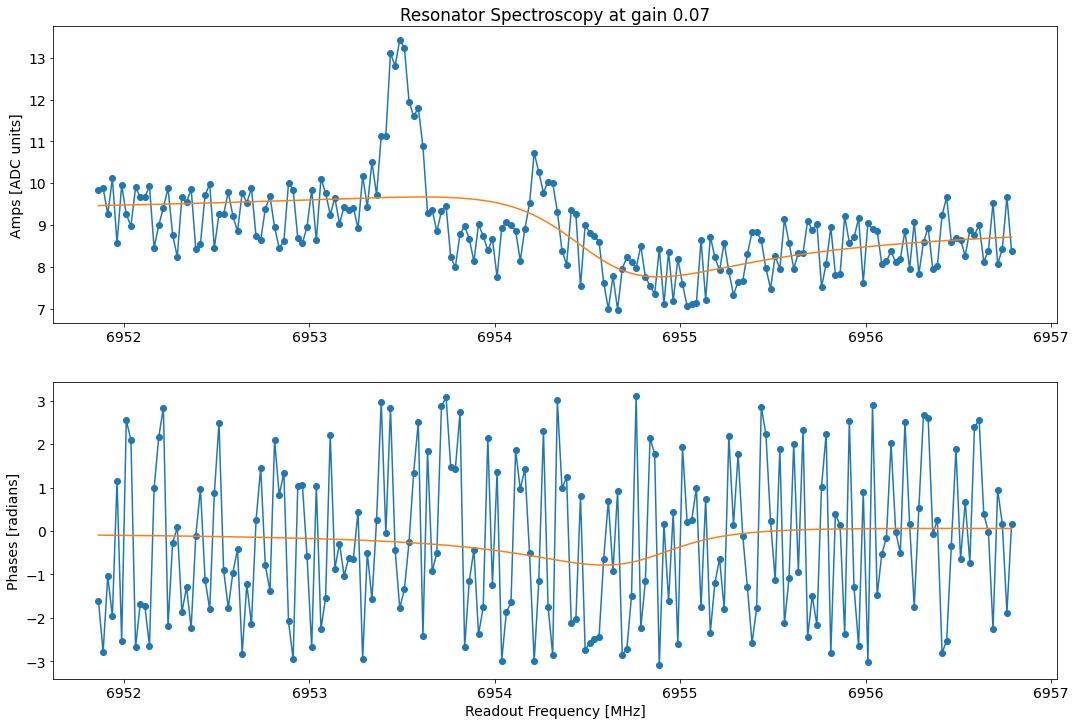

[{'Res freq': 7685.409984606071, 'Qubit freq': 4743.119391929708, 'Pi pulse gain': 27145, 'T1': 71.6106892555693, 'T1 err': 1.770328391690671, 'T2R': 4.553883430389113, 'T2R err': 0.25879416687841766, 'T2E': 7.469047929806235, 'T2E err': 0.4847131208841171, 'Res chi shift (e - g)': -1.8623824011605166, 'Res kappa': 0.2043546844468659}, {'Res freq': 5780.058197790235, 'Res kappa': 0.5203283105703349, 'Qubit freq': 3476.7161916434056, 'Pi pulse gain': 12821, 'T1': 138.4653086103976, 'T1 err': 27.326756075667646, 'T2R': 4.730417172183652, 'T2R err': 0.6133581671001253, 'T2E': 5.809460921334623, 'T2E err': 0.4673897710697129, 'Res chi shift (e - g)': -0.7905194975619452}, {'Res freq': 6792.632932164314, 'Res kappa': 0.21871865792055092, 'Qubit freq': 4166.521724424524, 'Pi pulse gain': 13968, 'T1': 43.655181478217216, 'T1 err': 1.249696907800396, 'T2R': 8.25462307373327, 'T2R err': 0.7569412447471384, 'T2E': 10.8646878658523, 'T2E err': 1.0690721702816643, 'Res chi shift (e - g)': -1.05147

In [ ]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
if not isinstance(rspecEF_chi_fit, (list, np.ndarray)):
    rspecEF_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspecEF_chi.display(fit=True)
res_freq_f = rspecEF_chi_fit[0]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [ ]:
if save_data: rspecEF_chi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_resonator_spectroscopy_chi_qubit3.h5


# Single Shot

## Single shot optimization

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

span_f = 2 # MHz
npts_f = 8

span_gain = 140
# npts_gain = 2
npts_gain = 7

span_len = 15 # us
# npts_len = 2
npts_len = 5

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=150,
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 35], 'T2R': [13, 20], 'f_ge': [3646.7584779001595, 4536.33065792081], 'f_ef': [3487.35, 4354.3124984175265], 'f_EgGf': 5243.181945338396, 'pulses': {'pi_ge': {'gain': [29284, 2154], 'sigma': [0.3, 0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [24292, 3586], 'sigma': [0.5, 0.02], 'type': 'gauss'}, 'pi_EgGf': {'gain': 15170, 'sigma': 0.4, 'type': 'gauss'}}}, 'readout': {'trig_offset': 180, 'frequency': [552.2, 1751.5253727591987], 'gain': [94, 255], 'phase': [-0.21743215294427692, -3.095165520548619], 'threshold': [72.01127819598226, -2.544007934071093], 'readout_length': [13, 22], 'relax_delay': [200, 150]}}, 'hw': {'lo': {'readout': {'frequency': '5.4e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [3, 1], 'nyquist': [2, 2]}, 'swap': {'ch': 1, 'nyquist': 2}, 'readout': {'ch': [0, 4], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC26C3', 'soc': 'Qick186'}, 'expt': {'reps': 100000, 'qubit': 1, 'start_f': 1750.025

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
shotopt.analyze()
print(shotopt.data['fid'])

(6, 6, 2)
[1750.02537276 1750.27537276 1750.52537276 1750.77537276 1751.02537276
 1751.27537276 1751.52537276 1751.77537276]
[150 170 190 210 230 250 270]
[10. 13. 16. 19. 22.]
Max fidelity 0.23594589864746618
Set params: 
 angle (deg) -4.944448307509958 
 threshold 3.277441669013662 
 freq [Mhz] 1751.5253727591987 
 gain [dac units] 270 
 readout length [us] 16.0
[[[0.01682008 0.01341007 0.01126006 0.01101006 0.01490007]
  [0.01511008 0.01690008 0.01728017 0.01579008 0.01560016]
  [0.01468015 0.01793009 0.01799009 0.01894009 0.0198303 ]
  [0.0196801  0.02366012 0.01772009 0.02299011 0.01835009]
  [0.01798009 0.0193801  0.02228011 0.02124011 0.0196401 ]
  [0.0201102  0.02239011 0.02387024 0.02159011 0.02301012]
  [0.02533013 0.02573039 0.02566026 0.02456025 0.02144011]]

 [[0.02697013 0.02618013 0.02557013 0.02589039 0.02283011]
  [0.02641013 0.02903015 0.02653013 0.02713014 0.02934015]
  [0.03406034 0.03354017 0.02885014 0.03038015 0.02783014]
  [0.03447052 0.0401702  0.03671018 0.038

In [ ]:
shotopt.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_single_shot_opt_qubit1.h5


## Best readout parameters

In [134]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=50000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=1751.5253727591987 
# shot.cfg.device.readout.gain=270
# shot.cfg.device.readout.readout_length = 16 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [72.0, 138.0, 50, 44], 'f_ge': [743.1193919297085, 3476.7161916434056, 168.08, 465.8], 'f_ef': [658, 3377, -55, 293], 'f_EgGf': [2000, 0, 2000, 2000], 'gs': [43, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 12821, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [1000, 1000, 1000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.4099846060709, -805.058197790235, -82, 80], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [215.0, 415.0, 150, 150]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Ig -32.46356538711776 +/- 17.90394385972816 	 Qg 4.049446974625894 +/- 17.858749443659963 	 Amp g 32.71515090052279
Ie -33.493819128171765 +/- 17.88972624055359 	 Qe 7.756994144437215 +/- 17.92363398723364 	 Amp e 34.380326902859984
fidelity: 0.08560085600856009
rotation angle (deg): -105.52955586018668
threshold: 11.020809714710055


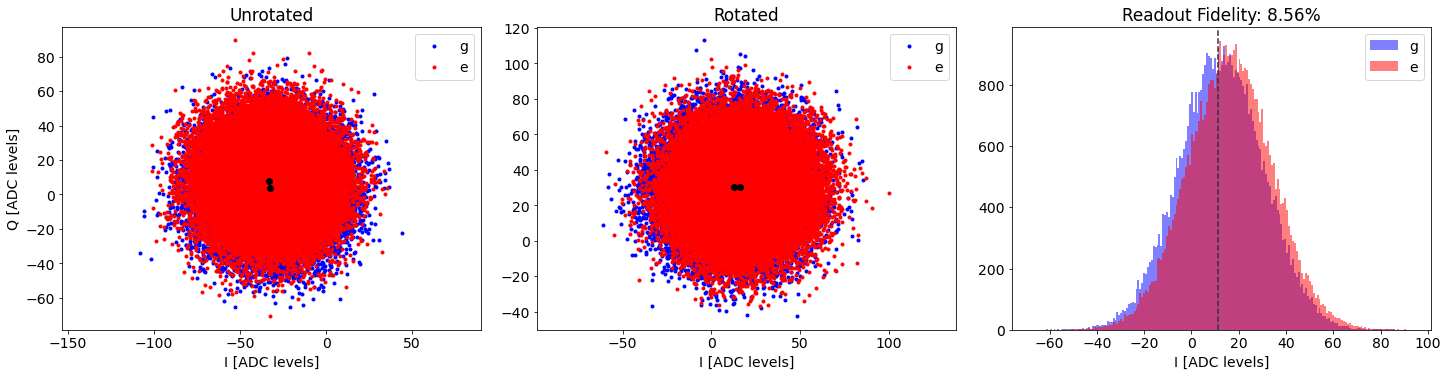

In [135]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [ ]:
shot.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_single_shot_qubit0.h5


# Results

In [360]:
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

Qubit 0
	Res freq: 7685.409984606071
	Qubit freq: 4743.119391929708
	Pi pulse gain: 27145
	T1: 71.6106892555693
	T1 err: 1.770328391690671
	T2R: 4.553883430389113
	T2R err: 0.25879416687841766
	T2E: 7.469047929806235
	T2E err: 0.4847131208841171
	Res chi shift (e - g): -1.8623824011605166
	Res kappa: 0.2043546844468659

Qubit 1
	Res freq: 5780.058197790235
	Res kappa: 0.5203283105703349
	Qubit freq: 3476.7161916434056
	Pi pulse gain: 12821
	T1: 138.4653086103976
	T1 err: 27.326756075667646
	T2R: 4.730417172183652
	T2R err: 0.6133581671001253
	T2E: 5.809460921334623
	T2E err: 0.4673897710697129
	Res chi shift (e - g): -0.7905194975619452

Qubit 2
	Res freq: 6792.632932164314
	Res kappa: 0.21871865792055092
	Qubit freq: 4166.521724424524
	Pi pulse gain: 13968
	T1: 43.655181478217216
	T1 err: 1.249696907800396
	T2R: 8.25462307373327
	T2R err: 0.7569412447471384
	T2E: 10.8646878658523
	T2E err: 1.0690721702816643
	Res chi shift (e - g): -1.0514792113223734

Qubit 3
	Res freq: 6954.33727631